In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import Literal

from matplotlib import pyplot as plt
from shapely.geometry import Point
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import numpy as np

from s2shores.bathy_debug.spatial_correlation_bathy_estimator_debug import SpatialCorrelationBathyEstimatorDebug
from s2shores.bathy_debug.spatial_correlation_wave_fields_display import (
    build_sinograms_1D_analysis_spatial_correlation,
    build_sinograms_spatial_correlation,
    build_waves_images_spatial_correl,
)
from s2shores.bathy_debug.waves_image_display import (
    create_pseudorgb,
    build_display_waves_image,
    build_display_pseudorgb,
)
from s2shores.bathy_physics import celerity_offshore, period_offshore, wavelength_offshore
from s2shores.generic_utils.image_filters import circular_masking
from s2shores.generic_utils.image_utils import normalized_cross_correlation
from s2shores.generic_utils.signal_utils import find_period_from_zeros
from s2shores.generic_utils.symmetric_radon import symmetric_radon
from s2shores.image_processing.waves_radon import WavesRadon
from s2shores.image_processing.waves_sinogram import WavesSinogram
from s2shores.bathy_debug.display_utils import get_display_title_with_kernel
from s2shores.bathy_debug.sinogram_display import (
    build_sinogram_display, 
    build_sinogram_difference_display,
    build_sinogram_1D_display_master,
    build_sinogram_1D_cross_correlation,
    build_sinogram_1D_display_slave,
    build_sinogram_2D_cross_correlation,
)
from s2shores.global_bathymetry.bathy_config import (
    BathyConfig,
    GlobalEstimatorConfig,
    SpatialCorrelationConfig,
)
from s2shores.waves_exceptions import WavesEstimationError, NotExploitableSinogram
from utils import initialize_sequential_run, read_config

## Coastal Bathymetry Estimation via Spatial Correlation

This notebook implements a bathymetric method using satellite imagery based on **spatial correlation** and the **linear relationship between water depth and wave kinematics**.  
Wave kinematics are inferred through the **spatial correlation of the wave field**, measured from two satellite images acquired within a short time interval.  
By leveraging the theory of linear wave dispersion in shallow water, bathymetry can be estimated from the wavelength of the waves.

## Notebook Objective

This notebook provides an **experimental and interactive** environment to:
- explore and adjust the key processing steps,
- quickly test different parameters and method variations,
- support **iterative development** of the processing workflow in a prototyping context.
## Notebook Summary

1. **Preprocess the images**: Apply filters on the images.
2. **Find the direction**: Calculate the main propagation direction of the waves.
3. **Compute the Radon transforms**: Compute Radon transforms on all images.
4. **Compute the spatial correlation**: Compute the spatial correlations of the radon transform on the main direction.
5. **Compute the wavelength**: Compute the wavelength of the waves based on the period of the spatial correlation.
6. **Compute the delta position**: Compute the depth estimation from the wavelength.

In [3]:
base_path = Path("../TestsS2Shores").resolve()
test_case: Literal["7_4", "8_2"] = "8_2"
method: Literal["spatial_corr", "spatial_dft", "temporal_corr"] = "spatial_corr"

product_path: Path = base_path / "products" / f"SWASH_{test_case}/testcase_{test_case}.tif"
config_path: Path = base_path / f"reference_results/debug_pointswash_{method}/wave_bathy_inversion_config.yaml"
debug_file: Path = base_path / f"debug_points/debug_points_SWASH_{test_case}.yaml"

estimation_point = Point(451.0, 499.0)

In [4]:
# config = read_config(config_path=config_path)

# OR

config = BathyConfig(
    GLOBAL_ESTIMATOR=GlobalEstimatorConfig(
        WAVE_EST_METHOD="SPATIAL_CORRELATION",
        SELECTED_FRAMES=[10, 13],
        DXP=50,
        DYP=500,
        NKEEP=5,
        WINDOW=400,
        SM_LENGTH=100,
        MIN_D=2,
        MIN_T=3,
        MIN_WAVES_LINEARITY=0.01,
    )
)

If you want to change any parameter of the configuration, modify the values of the object `config` as you would with a dict.  

Example:
```python
config["parameter"] = "new_value"
```

In [5]:
bathy_estimator, ortho_bathy_estimator, ortho_sequence = initialize_sequential_run(
    product_path=product_path,
    point=estimation_point,
    config=config,
)

/home/geoffrey/miniconda3/envs/s2shores_env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [6]:
local_estimator = SpatialCorrelationBathyEstimatorDebug(
    estimation_point,
    ortho_sequence,
    bathy_estimator,
)

if not local_estimator.can_estimate_bathy():
    raise WavesEstimationError("Cannot estimate bathy.")

## Preprocess images

Modified attributes:
- local_estimator.ortho_sequence.\<elements\>.pixels

In [7]:
from s2shores.generic_utils.image_filters import desmooth, detrend

if False:
    local_estimator.preprocess_images()
else:
    preprocessing_filters = [(detrend, [])]

    if bathy_estimator.smoothing_requested:
        # FIXME: pixels necessary for smoothing are not taken into account, thus
        # zeros are introduced at the borders of the window.

        preprocessing_filters += [
            (desmooth,
             [bathy_estimator.smoothing_lines_size,
              bathy_estimator.smoothing_columns_size]),
            # Remove tendency possibly introduced by smoothing, specially on the shore line
            (detrend, []),
        ]


    for image in local_estimator.ortho_sequence:
        filtered_image = image.apply_filters(preprocessing_filters)
        image.pixels = filtered_image.pixels

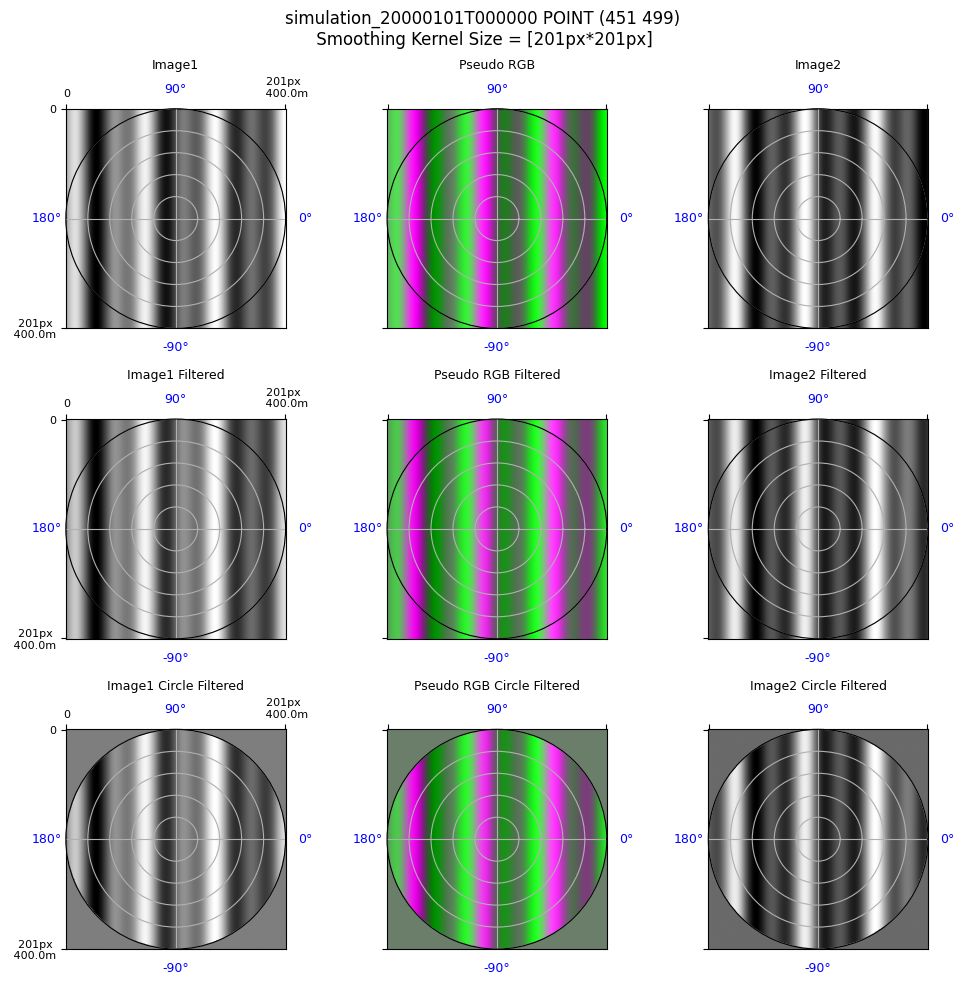

In [ ]:
if False:
    build_waves_images_spatial_correl(local_estimator)
else:
    nrows = 3
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)

    first_image = local_estimator.ortho_sequence[0]
    second_image = local_estimator.ortho_sequence[1]

    def plot_waves_row(
            fig,
            row_number: int,
            pixels1,
            resolution1,
            pixels2,
            resolution2,
            title_suffix: str = "",
            directions: list[tuple[float, int]] = None):
        build_display_waves_image(fig,
                                  axs[row_number, 0],
                                  f'Image1{title_suffix}',
                                  pixels1,
                                  resolution=resolution1,
                                  subplot_pos=[nrows, ncols, 1 + 3 * row_number],
                                  cmap='gray',
                                  directions=directions)
        build_display_pseudorgb(fig,
                                axs[row_number, 1],
                                f'Pseudo RGB{title_suffix}',
                                create_pseudorgb(pixels1, pixels2),
                                resolution=resolution1,
                                subplot_pos=[nrows, ncols, 2 + 3 * row_number],
                                directions=directions,
                                coordinates=False)
        build_display_waves_image(fig,
                                  axs[row_number, 2],
                                  f'Image2{title_suffix}',
                                  pixels2,
                                  resolution=resolution2,
                                  subplot_pos=[nrows, ncols, 3 + 3 * row_number],
                                  directions=directions,
                                  cmap='gray',
                                  coordinates=False)


    # First Plot line = Image1 / pseudoRGB / Image2
    plot_waves_row(fig=fig,
                   row_number=0,
                   pixels1=first_image.original_pixels,
                   resolution1=first_image.resolution,
                   pixels2=second_image.original_pixels, 
                   resolution2=first_image.resolution)
    # Second Plot line = Image1 Filtered / pseudoRGB Filtered/ Image2 Filtered
    plot_waves_row(fig=fig,
                   row_number=1,
                   pixels1=first_image.pixels,
                   resolution1=first_image.resolution,
                   pixels2=second_image.pixels, 
                   resolution2=first_image.resolution,
                   title_suffix=" Filtered")

    # Third Plot line = Image1 Circle Filtered / pseudoRGB Circle Filtered/ Image2 Circle Filtered
    plot_waves_row(fig=fig,
                   row_number=2,
                   pixels1=first_image.pixels * first_image.circle_image,
                   resolution1=first_image.resolution,
                   pixels2=second_image.pixels * second_image.circle_image, 
                   resolution2=first_image.resolution,
                   title_suffix=" Circle Filtered")
    plt.tight_layout()

## Find direction

Modified attributes:
- None

New variables:
- estimated_direction

In [8]:
if False:
    estimated_direction = local_estimator.find_direction()
else:

    # Start: WavesRadon(self.ortho_sequence[0], self.selected_directions)
    image = local_estimator.ortho_sequence[0]
    sampling_frequency = 1. / image.resolution
    selected_directions = local_estimator.selected_directions

    pixels = circular_masking(image.pixels.copy())
    radon_transform = symmetric_radon(image=pixels, theta=selected_directions)

    waves_radon = {
        direction: radon_transform[:, idx]
        for idx, direction in enumerate(selected_directions)
    }
    # End: WavesRadon


    # Start: WavesRadon.get_direction_maximum_variance()

    # Start: Sinograms.get_sinograms_variances(selected_directions)
    variances = np.empty(len(selected_directions), dtype=np.float64)
    for result_index, direction in enumerate(selected_directions):
        variances[result_index] = float(np.var(waves_radon[direction]))
    # End: Sinograms.get_sinograms_variances

    index_max_variance = np.argmax(variances)
    estimated_direction = selected_directions[index_max_variance]
    # End: WavesRadon.get_direction_maximum_variance

estimated_direction

-180.0

In [9]:
# TODO: check if that's correct
if not np.isnan(estimated_direction):
    if estimated_direction < 0:
        main_direction = estimated_direction + 180
    else:
        main_direction = estimated_direction

- Pas de flêche de la direction dans le 1er graphe
- main direction <> estimated direction: opposées. Est-ce que c'est important ?

## Compute radon transforms

New elements:
- local_estimator.randon_transforms

In [10]:
from s2shores.image_processing.waves_radon import linear_directions

# For debugging, all plotted directions need to be computed
plt_min = local_estimator.global_estimator.local_estimator_params['DEBUG']['PLOT_MIN']
plt_max = local_estimator.global_estimator.local_estimator_params['DEBUG']['PLOT_MAX']
min_dir = min(plt_min, min(selected_directions))
max_dir = max(plt_max, max(selected_directions))
selected_directions = linear_directions(angle_min=min_dir, angle_max=max_dir, angles_step=1)

# Reset radon transforms when cell is re-run
local_estimator.radon_transforms = []

if False:
    local_estimator.compute_radon_transforms(estimated_direction)
else:
    for image in local_estimator.ortho_sequence:
        # Start: WavesRadon(image, np.array([estimated_direction]))
        sampling_frequency = 1. / image.resolution

        pixels = circular_masking(image.pixels.copy())
        radon_transform = symmetric_radon(image=pixels, theta=selected_directions)

        waves_radon = {
            direction: radon_transform[:, idx]
            for idx, direction in enumerate(selected_directions)
        }
        # End: WavesRadon
        
        # Start: Sinograms.radon_augmentation(self.radon_augmentation_factor)
        radon_augmented = {}
        for direction, values in waves_radon.items():
            current_axis = np.linspace(0, values.size - 1, values.size)
            nb_over_samples = round(((values.size - 1) / local_estimator.radon_augmentation_factor) + 1)
            new_axis = np.linspace(
                start=0,
                stop=values.size - 1,
                num=nb_over_samples,
            )
            interpolating_func = interp1d(current_axis, values, kind='linear', assume_sorted=True)
            radon_augmented[direction] = interpolating_func(new_axis)
        # End: Sinograms.radon_augmentation(self.radon_augmentation_factor)

        local_estimator.radon_transforms.append(radon_augmented)

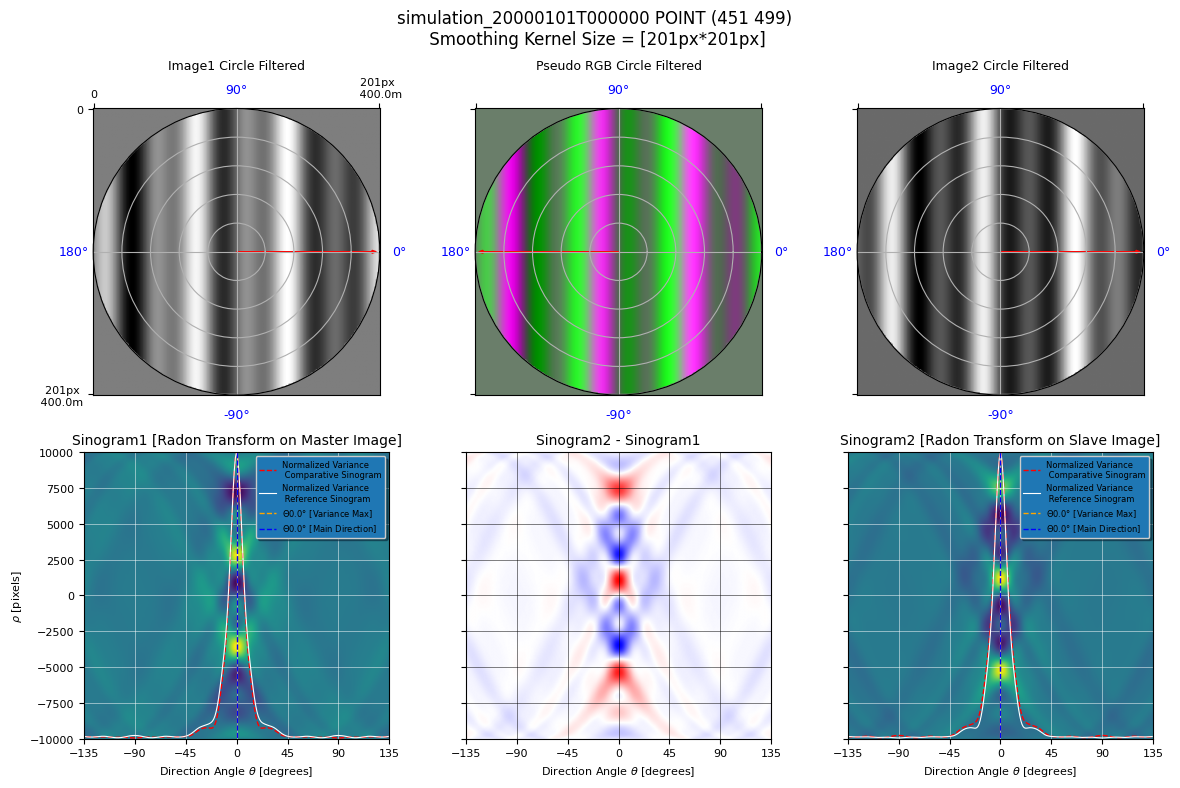

In [13]:
if False:
    build_sinograms_spatial_correlation(local_estimator)
else:
    nrows = 2
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)
    first_image = local_estimator.ortho_sequence[0]
    second_image = local_estimator.ortho_sequence[1]

    arrows = [(main_direction, np.shape(first_image.original_pixels)[0])]

    # First Plot line = Image1 Circle Filtered / pseudoRGB Circle Filtered/ Image2 Circle Filtered
    plot_waves_row(
        fig=fig,
        row_number=0,
        pixels1=first_image.pixels * first_image.circle_image,
        resolution1=first_image.resolution,
        pixels2=second_image.pixels * second_image.circle_image,
        resolution2=first_image.resolution,
        title_suffix=" Circle Filtered",
        directions=arrows,
    )

    # Second Plot line = Sinogram1 / Sinogram2-Sinogram1 / Sinogram2
    first_radon_transform = local_estimator.radon_transforms[0]
    second_radon_transform = local_estimator.radon_transforms[1]

    nb_samples = next(iter(first_radon_transform.values())).shape[0]
    sinogram1 = np.empty((nb_samples, len(selected_directions)))
    sinogram2 = np.empty((nb_samples, len(selected_directions)))

    for index, direction in enumerate(selected_directions):
        sinogram1[:, index] = first_radon_transform[direction]
        sinogram2[:, index] = second_radon_transform[direction]

    radon_difference = (sinogram2 / np.max(np.abs(sinogram2))) - \
        (sinogram1 / np.max(np.abs(sinogram1)))

    plt_min = local_estimator.global_estimator.local_estimator_params['DEBUG']['PLOT_MIN']
    plt_max = local_estimator.global_estimator.local_estimator_params['DEBUG']['PLOT_MAX']


    build_sinogram_display(
        axes=axs[1, 0],
        title='Sinogram1 [Radon Transform on Master Image]',
        values1=sinogram1,
        directions=selected_directions,
        values2=sinogram2,
        main_theta=main_direction,
        plt_min=plt_min,
        plt_max=plt_max,
    )
    build_sinogram_difference_display(
        axes=axs[1, 1],
        title='Sinogram2 - Sinogram1',
        values=radon_difference,
        directions=selected_directions,
        plt_min=plt_min,
        plt_max=plt_max,
        cmap='bwr',
    )
    build_sinogram_display(
        axes=axs[1, 2],
        title='Sinogram2 [Radon Transform on Slave Image]',
        values1=sinogram2,
        directions=selected_directions,
        values2=sinogram1,
        main_theta=main_direction,
        plt_min=plt_min,
        plt_max=plt_max,
        ordonate=False,
    )

    plt.tight_layout()

**Est-ce qu'on doit prendre le radon_augmented ou le radon de base comme la méthode originale ?**

## Compute spatial correlation

New elements:
- local_estimator.sinograms

New variables:
- correlation_signal

In [14]:
local_estimator.sinograms = []

if False:
    correlation_signal = local_estimator.compute_spatial_correlation(estimated_direction)
else:
    for radon_transform in local_estimator.radon_transforms:
        values = radon_transform[estimated_direction]
        values *= float(np.var(values))
        local_estimator.sinograms.append(values)
    # TODO: should be independent from 0/1 (for multiple pairs of frames)
    sinogram_1 = local_estimator.sinograms[0]
    sinogram_2 = local_estimator.sinograms[1]
    correl_mode = local_estimator.local_estimator_params['CORRELATION_MODE']
    corr_init = normalized_cross_correlation(sinogram_1, sinogram_2, correl_mode)
    corr_init_ac = normalized_cross_correlation(corr_init, corr_init, correl_mode)
    corr_1 = normalized_cross_correlation(corr_init_ac, sinogram_1, correl_mode)
    corr_2 = normalized_cross_correlation(corr_init_ac, sinogram_2, correl_mode)
    correlation_signal = normalized_cross_correlation(corr_1, corr_2, correl_mode)

correlation_signal

array([0.17217606, 0.17246987, 0.17276372, ..., 0.13137046, 0.13173335,
       0.13209611])

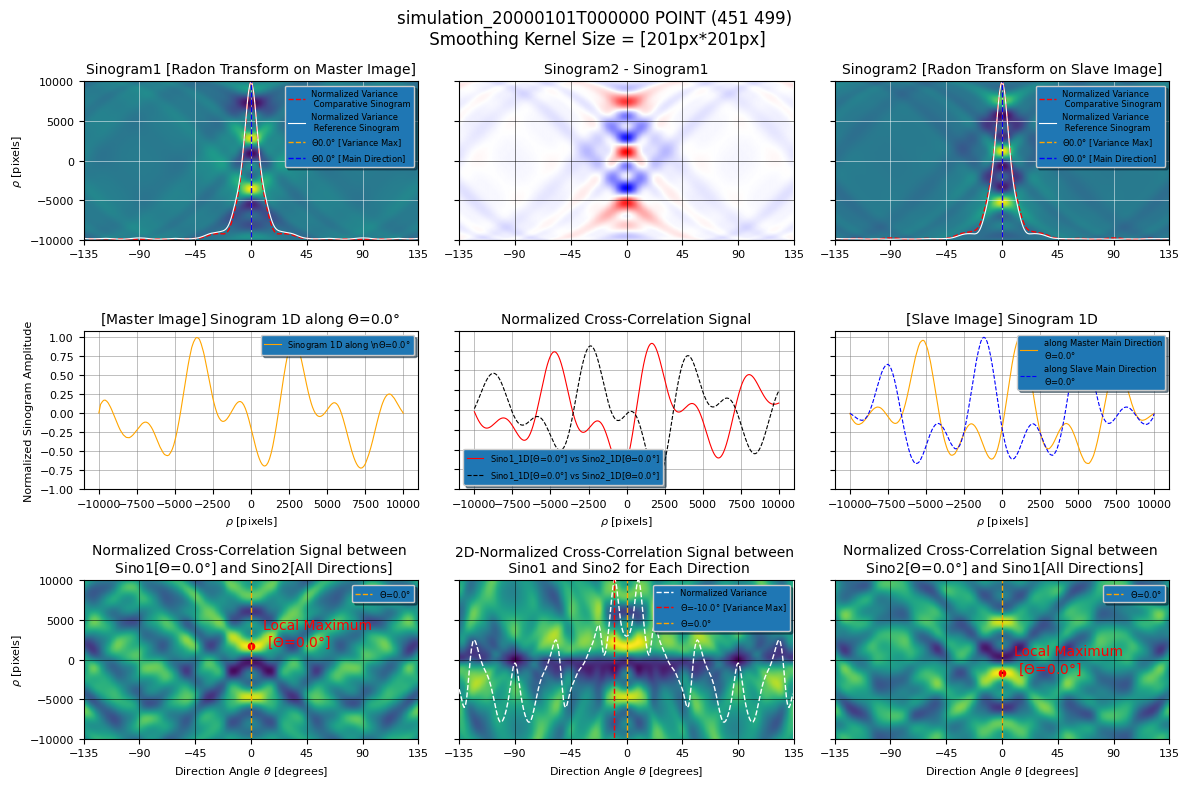

In [17]:
nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)


# First Plot line = Sinogram1 / Sinogram2-Sinogram1 / Sinogram2
radon_difference = (sinogram2 / np.max(np.abs(sinogram2))) - \
    (sinogram1 / np.max(np.abs(sinogram1)))

build_sinogram_display(
    axes=axs[0, 0],
    title='Sinogram1 [Radon Transform on Master Image]',
    values1=sinogram1,
    directions=selected_directions,
    values2=sinogram2,
    main_theta=main_direction,
    plt_min=plt_min,
    plt_max=plt_max,
    abscissa=False,
)
build_sinogram_difference_display(
    axs[0, 1],
    'Sinogram2 - Sinogram1',
    radon_difference,
    selected_directions,
    plt_min,
    plt_max,
    abscissa=False,
    cmap='bwr',
)
build_sinogram_display(
    axs[0, 2],
    'Sinogram2 [Radon Transform on Slave Image]',
    sinogram2,
    selected_directions,
    sinogram1,
    main_direction,
    plt_min,
    plt_max,
    ordonate=False,
    abscissa=False,
)

# Second Plot line = SINO_1 [1D along estimated direction] / Cross-Correlation Signal /
# SINO_2 [1D along estimated direction resulting from Image1]
# Check if the main direction belongs to the plotting interval [plt_min:plt_max]
if main_direction < plt_min or main_direction > plt_max:
    theta_label = main_direction % (-np.sign(main_direction) * 180.0)
else:
    theta_label = main_direction
title_sino1 = '[Master Image] Sinogram 1D along $\\Theta$={:.1f}° '.format(theta_label)
title_sino2 = '[Slave Image] Sinogram 1D'.format(theta_label)
correl_mode = local_estimator.global_estimator.local_estimator_params['CORRELATION_MODE']

build_sinogram_1D_display_master(
    axs[1, 0],
    title_sino1,
    sinogram1,
    selected_directions,
    main_direction,
    plt_min,
    plt_max,
)
build_sinogram_1D_cross_correlation(
    axs[1, 1],
    'Normalized Cross-Correlation Signal',
    sinogram1,
    selected_directions,
    main_direction,
    sinogram2,
    selected_directions,
    plt_min,
    plt_max,
    correl_mode,
    ordonate=False,
)
build_sinogram_1D_display_slave(
    axs[1, 2],
    title_sino2,
    sinogram2,
    selected_directions,
    main_direction,
    plt_min,
    plt_max,
    ordonate=False,
)

# Third Plot line = Image [2D] Cross correl Sino1[main dir] with Sino2 all directions /
# Image [2D] of Cross correlation 1D between SINO1 & SINO 2 for each direction /
# Image [2D] Cross correl Sino2[main dir] with Sino1 all directions
# Check if the main direction belongs to the plotting interval [plt_min:plt_ramax]

title_cross_correl1 = 'Normalized Cross-Correlation Signal between \n Sino1[$\\Theta$={:.1f}°] and Sino2[All Directions]'.format(
    theta_label)
title_cross_correl2 = 'Normalized Cross-Correlation Signal between \n Sino2[$\\Theta$={:.1f}°] and Sino1[All Directions]'.format(
    0)
title_cross_correl_2D = '2D-Normalized Cross-Correlation Signal between \n Sino1 and Sino2 for Each Direction'

build_sinogram_2D_cross_correlation(
    axs[2, 0],
    title_cross_correl1,
    sinogram1,
    selected_directions,
    main_direction,
    sinogram2,
    plt_min,
    plt_max,
    correl_mode,
    choice='one_dir',
    imgtype='master',
)
build_sinogram_2D_cross_correlation(
    axs[2, 1],
    title_cross_correl_2D,
    sinogram1,
    selected_directions,
    main_direction,
    sinogram2,
    plt_min,
    plt_max,
    correl_mode,
    choice='all_dir',
    imgtype='master',
    ordonate=False,
)
build_sinogram_2D_cross_correlation(
    axs[2, 2],
    title_cross_correl2,
    sinogram2,
    selected_directions,
    main_direction,
    sinogram1,
    plt_min,
    plt_max,
    correl_mode,
    choice='one_dir',
    imgtype='slave',
    ordonate=False,
)

plt.tight_layout()

## Compute wavelength

Modified attributes:
- None

New variables:
- wavelength

In [19]:
if False:
    wavelength = local_estimator.compute_wavelength(correlation_signal)
else:
    min_wavelength = wavelength_offshore(
        local_estimator.global_estimator.waves_period_min,
        local_estimator.gravity,
    )
    min_period_unitless = int(min_wavelength / local_estimator.augmented_resolution)
    try:
        period, _ = find_period_from_zeros(correlation_signal, min_period_unitless)
        wavelength = period * local_estimator.augmented_resolution
    except ValueError as excp:
        raise NotExploitableSinogram('Wave length can not be computed from sinogram') from excp
    
wavelength

134.68150021791905

## Compute delta position

Modified attributes:
- None

New variables:
- delta_position

In [20]:
if False:
    delta_position = local_estimator.compute_delta_position(correlation_signal, wavelength)
else:
    peaks_pos, _ = find_peaks(correlation_signal)
    if peaks_pos.size == 0:
        raise WavesEstimationError('Unable to find any directional peak')
    argmax_ac = len(correlation_signal) // 2
    relative_distance = (peaks_pos - argmax_ac) * local_estimator.augmented_resolution

    celerity_offshore_max = celerity_offshore(
        local_estimator.global_estimator.waves_period_max,
        local_estimator.gravity,
    )
    spatial_shift_offshore_max = celerity_offshore_max * local_estimator.propagation_duration
    spatial_shift_min = min(-spatial_shift_offshore_max, spatial_shift_offshore_max)
    spatial_shift_max = -spatial_shift_min

    stroboscopic_factor_offshore = local_estimator.propagation_duration / period_offshore(
        1 / wavelength, local_estimator.gravity)
    
    if abs(stroboscopic_factor_offshore) >= 1:
        # unused for s2
        print('test stroboscopie vrai')
        spatial_shift_offshore_max = (
            local_estimator.local_estimator_params['PEAK_POSITION_MAX_FACTOR']
            * stroboscopic_factor_offshore
            * wavelength
        )

    pt_in_range = peaks_pos[np.where(
        (relative_distance >= spatial_shift_min)
        & (relative_distance < spatial_shift_max)
    )]
    if pt_in_range.size == 0:
        raise WavesEstimationError('Unable to find any directional peak')
    argmax = pt_in_range[correlation_signal[pt_in_range].argmax()]
    delta_position = (argmax - argmax_ac) * local_estimator.augmented_resolution

delta_position

-38.800000000000004

## Save wave field estimation

New elements:
- local_estimator.bathymetry_estimations

In [21]:
if False:
    local_estimator.save_wave_field_estimation(estimated_direction, wavelength, delta_position)
else:
    bathymetry_estimation = local_estimator.create_bathymetry_estimation(estimated_direction, wavelength)
    bathymetry_estimation.delta_position = delta_position
    local_estimator.bathymetry_estimations.append(bathymetry_estimation)

bathymetry_estimation.is_physical()

True